# Future plan
- polar coordinates
- local max/min feature
- distance map

In [1]:
# imports
import numpy as np                     # numeric python lib

import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour

from skimage import measure            # to find shape contour
import scipy.ndimage as ndi            # to determine shape centrality


# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots

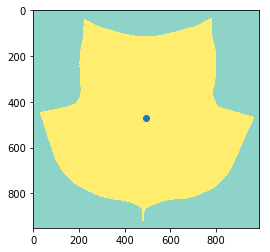

In [5]:
# reading an image file using matplotlib into a numpy array
img = mpimg.imread('../input/images/48.jpg')

# using image processing module of scipy to find the center of the leaf
cy, cx = ndi.center_of_mass(img)

plt.imshow(img, cmap='Set3')  # show me the leaf
plt.scatter(cx, cy)           # show me its center
plt.show()

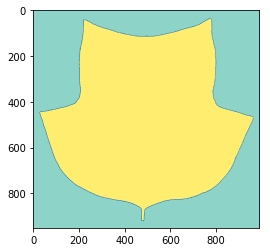

In [6]:
# scikit-learn imaging contour finding, returns a list of found edges
contours = measure.find_contours(img, .8)

# from which we choose the longest one
contour = max(contours, key=len)

# let us see the contour that we hopefully found
plt.plot(contour[::,1], contour[::,0], linewidth=0.5)  # (I will explain this [::,x] later)
plt.imshow(img, cmap='Set3')
plt.show()

Now we can project this contour - that is, thousands of pairs of (x,y) coordinates - into the Polar coordinate system.
![Cartesian to Polar][1]
[1]: http://jwilson.coe.uga.edu/emat6680fa11/lee/asnmt11hylee/fig2.jpg

Demean (making its mean 0 by shifting points) is needed: the polar coordnate projection failed to yield what we want, because the shape is in the +,+ part of the Cartesian system, not around the center.

Why the contour, why not the image? First, image is big, contour is small. Second, image is just hundreds n hundreds of bits on a grid, not (x,y) pairs. It is not the right data format for us.

In [8]:
# numpy is smart and assumes the same about us
# if we substract a number from an array of numbers,
# it assumes that we wanted to substract from all members
contour[::,1] -= cx  # demean X
contour[::,0] -= cy  # demean Y

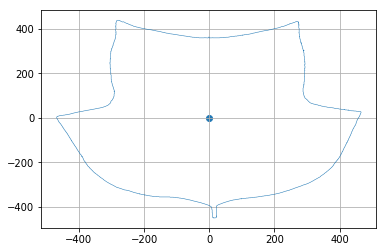

In [9]:
# checking if we succeeded to move the center to (0,0)
plt.plot(-contour[::,1], -contour[::,0], linewidth=0.5)
plt.grid()
plt.scatter(0, 0)
plt.show()

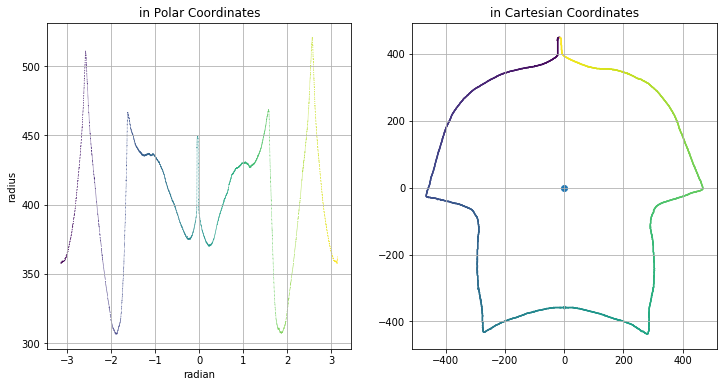

In [10]:
# just calling the transformation on all pairs in the set
polar_contour = np.array([cart2pol(x, y) for x, y in contour])

# and plotting the result
rcParams['figure.figsize'] = (12, 6)
plt.subplot(121)
plt.ylabel('radius')
plt.xlabel('radian')
plt.scatter(polar_contour[::,1], polar_contour[::,0], linewidth=0, s=.5, c=polar_contour[::,1])
plt.title('in Polar Coordinates')
plt.grid()
plt.subplot(122)
plt.scatter(contour[::,1],             # x axis is radians
            contour[::,0],             # y axis is distance from center
            linewidth=0, s=2,          # small points, w/o borders
            c=range(len(contour)))     # continuous coloring (so that plots match)
plt.scatter(0, 0)
plt.title('in Cartesian Coordinates')
plt.grid()
plt.show()

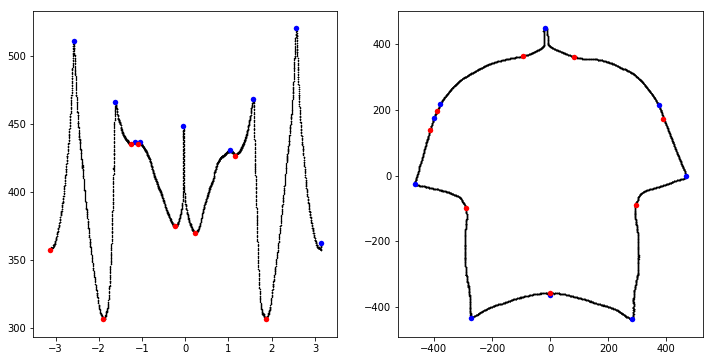

In [11]:
from scipy.signal import argrelextrema

# for local maxima
c_max_index = argrelextrema(polar_contour[::,0], np.greater, order=50)
c_min_index = argrelextrema(polar_contour[::,0], np.less, order=50)

plt.subplot(121)
plt.scatter(polar_contour[::,1], polar_contour[::,0], 
            linewidth=0, s=2, c='k')
plt.scatter(polar_contour[::,1][c_max_index], 
            polar_contour[::,0][c_max_index], 
            linewidth=0, s=30, c='b')
plt.scatter(polar_contour[::,1][c_min_index], 
            polar_contour[::,0][c_min_index], 
            linewidth=0, s=30, c='r')

plt.subplot(122)
plt.scatter(contour[::,1], contour[::,0], 
            linewidth=0, s=2, c='k')
plt.scatter(contour[::,1][c_max_index], 
            contour[::,0][c_max_index], 
            linewidth=0, s=30, c='b')
plt.scatter(contour[::,1][c_min_index], 
            contour[::,0][c_min_index], 
            linewidth=0, s=30, c='r')

plt.show()

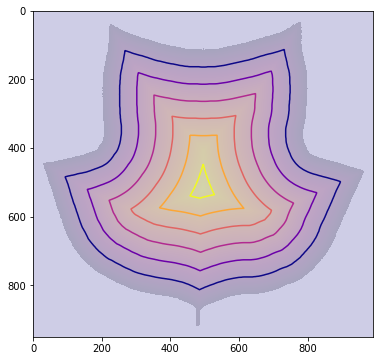

In [12]:
# While I was looking up how to threshold an image, I have found this.
# The further away from the edges a pixel is, the higher value it gets.
# This is important, because it describes the morphology of the leaf better, 
# than a simple euclidean distance from the center, because it considers
# concave parts differently, and that's an important feature I wish to keep.

# This is very promising. Using this, I will probably be able to find symmetry.

# I also believe, that using this distance map, I will be able to separate
# the core shape of the leaf and the edge texture, which are two distinct,
# pretty good features.

dist_2d = ndi.distance_transform_edt(img)
plt.imshow(img, cmap='Greys', alpha=.2)
plt.imshow(dist_2d, cmap='plasma', alpha=.2)
plt.contour(dist_2d, cmap='plasma')
plt.show()